In [29]:
import torch
import torch.nn as tNN
import torch.linalg as tla
import numml.sparse as sp
import numml.nn as nNN
import numml.krylov as kry
import matplotlib.pyplot as plt

In [3]:
N = 16
A = sp.eye(N) * 2 - sp.eye(N,k=-1) - sp.eye(N,k=1)

In [34]:
# Use our GCN implementation to create a network that maps right-hand-side
# for a matrix to a guess to a solution of Ax=b

class Network(tNN.Module):
    def __init__(self, H):
        super().__init__()
        
        self.conv1 = nNN.GCNConv(1, H, normalize=False)
        self.conv2 = nNN.GCNConv(H, H, normalize=False)
        self.conv3 = nNN.GCNConv(H, H, normalize=False)
        self.conv4 = nNN.GCNConv(H, 1, normalize=False)
        self.upscale = tNN.Linear(1, H)
        self.downscale = tNN.Linear(H, 1)
    
    def forward(self, A, X):
        X = torch.tanh(self.conv1(A, X)) + self.upscale(torch.unsqueeze(X, 1))
        X = torch.tanh(self.conv2(A, X)) + X
        X = torch.tanh(self.conv3(A, X)) + X
        X = torch.tanh(self.conv4(A, X)) + self.downscale(X)
        X = torch.squeeze(X)
        return X

In [41]:
# Optimize over the entries of the network, not totally working yet...

network = Network(5)
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

N_e = 1_000
N_b = 100

for i in range(N_e):
    optimizer.zero_grad()
    l = 0.
    for j in range(N_b):
        b = torch.randn(N)
        x_g = network(A, b)
        r = b - (A @ x_g)
        rr = (r@r)/(b@b)
        l += rr
    l.backward()
    optimizer.step()
    print(i, l.item()/N_b)

0 18.43362060546875
1 12.236219482421875
2 9.604313354492188
3 6.903157348632813
4 5.382106323242187
5 3.4203448486328125
6 2.5836410522460938
7 2.18237548828125
8 2.2529057312011718
9 1.7897819519042968
10 1.4383049011230469
11 1.4072232055664062
12 1.569441680908203
13 1.426100311279297
14 1.1547177124023438
15 1.4302890014648437
16 1.35812255859375
17 1.1883541870117187
18 1.33385009765625
19 1.2761290740966797
20 1.154659423828125
21 1.2076583862304688
22 1.1114271545410157
23 1.0894998931884765
24 1.2081683349609376
25 1.0241873168945312
26 1.074855728149414
27 1.0314786529541016
28 1.095553207397461
29 1.018197021484375
30 1.0491429901123046
31 0.908709716796875
32 0.9502206420898438
33 0.9721773529052734
34 0.9283194732666016
35 0.9790439605712891
36 0.9359761810302735
37 0.8493215942382812
38 0.8717283630371093
39 0.9723683166503906
40 0.8816755676269531
41 0.9225838470458985
42 0.8411797332763672
43 0.9934860992431641
44 0.7926951599121094
45 0.8028867340087891
46 0.8239342498

KeyboardInterrupt: 

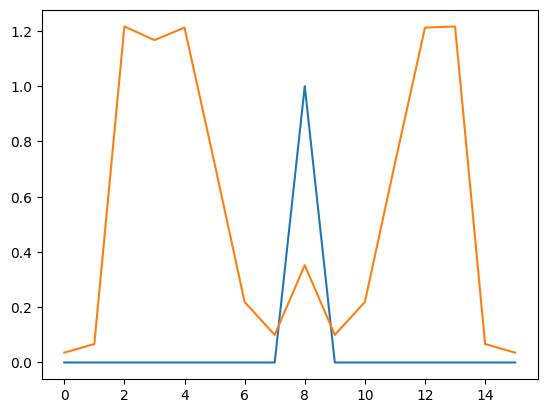

In [42]:
b = torch.zeros(N)
b[N//2] = 1.

plt.plot(b)
plt.plot(network(A, b).detach().cpu())